# Multi-class Classification
For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9).<br> Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes) on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.<br>
In the first part of the exercise, you will extend your previous implemention of <strong>logistic regression</strong> and apply it to <strong>one-vs-all classification</strong>.<br><br>

The file <strong><em>ex3data1</em></strong> contains a training set.<br>
The structure of the dataset described blow:<br>
1. X array = <strong>400 columns describe the values of pixels of 20*20 images in flatten format for 5000 samples</strong>
2. y array = <strong>Value of image (number between 0-9)</strong>


<br><br>
<strong>
Our assignment has these sections:
1. Visualizing the Data
    1. Converting .mat to .csv
    2. Loading Dataset
    3. Ploting Data
2. Vectorizing Logistic Regression
    1. Vectorizing the cost function
    2. Vectorizing the gradient
    3. Vectorizing regularized logistic regression
3. One-vs-all Classification
    1. One-vs-all Prediction
</strong>

In each section full description provided.

## 1. Visualizing the Dataset
Before starting on any task, it is often useful to understand the data by visualizing it.<br>

### 1.A Converting .mat to .csv
In this specific assignment, the instructor added a .mat file as training set. But we have to convert it to .csv to use in python.<br>
After all we now ready to import our new csv files to pandas dataframes and do preprocessing on it and make it ready for next steps.

In [1]:
# import libraries
import scipy.io
import numpy as np

data = scipy.io.loadmat("ex3data1")

Now we extract X and y variables from the .mat file and save them into .csv file for further usage. After running the below code <strong>you should see X.csv and y.csv files</strong> in your directory.

In [2]:
for i in data:
    if '__' not in i and 'readme' not in i:
        np.savetxt((i+".csv"),data[i],delimiter=',')

### 1.B Loading Dataset
First we import .csv files into pandas dataframes then save them into numpy arrays.<br><br>
There are <strong>5000 training examples</strong> in ex3data1.mat, where each training example is a <strong>20 pixel by 20 pixel <em>grayscale</em> image of the digit</strong>. Each pixel is represented by a floating point number indicating the <strong>grayscale intensity</strong> at that location. The 20 by 20 grid of pixels is <strong>"flatten" into a 400-dimensional vector</strong>. <strong>Each of these training examples becomes a single row in our data matrix X</strong>. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.<br>
The structure of X is look like this: <img src='img/x.jpg'><br>
The second part of the training set is a <strong>5000-dimensional vector y that contains labels</strong> for the training set.<br><br>
<strong>Notice: In dataset, the digit zero mapped to the value ten. Therefore, a "0" digit is labeled as "10", while the digits "1" to "9" are labeled as "1" to "9" in their natural order.

In [3]:
# import library
import pandas as pd

# saving .csv files to pandas dataframes
x_df = pd.read_csv('X.csv',names= np.arange(0,400))
y_df = pd.read_csv('y.csv',names=['label'])

In [4]:
# saving x_df and y_df into numpy arrays
x = x_df.iloc[:,:].values
y = y_df.iloc[:,:].values
m, n = x.shape
print('#{} Number of training samples, #{} features per sample'.format(m,n))

#5000 Number of training samples, #400 features per sample


### 1.C Plotting Data
You will begin by visualizing a subset of the training set. In first part, the code <strong>randomly selects selects 100 rows from X</strong> and passes those rows to the <strong>display_data</strong> function. This function maps each row to a 20 pixel by 20 pixel grayscale image and displays the images together.<br>
After plotting, you should see an image like this:<img src='img/plot.jpg'>

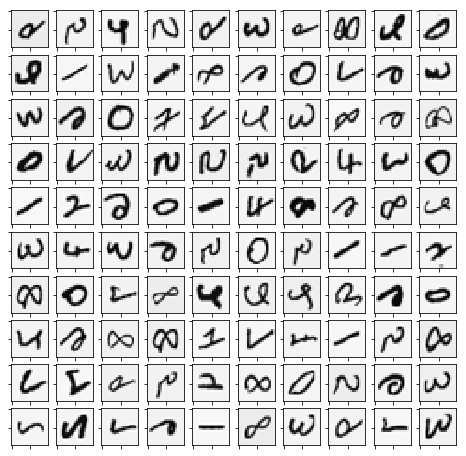

[  9.   5.   2.   5.   9.   3.   9.   8.   2.  10.   2.   1.   3.   1.   8.
   6.  10.   7.   6.   3.   3.   6.  10.   4.   7.   2.   3.   8.   6.   8.
  10.   7.   3.   5.   5.   5.   9.   7.   3.  10.   1.   4.   6.  10.   1.
   7.   8.   6.   8.   2.   3.   7.   3.   6.   5.  10.   5.   1.   1.   4.
   8.  10.   7.   8.   2.   2.   2.   9.   6.  10.   2.   6.   8.   8.   4.
   7.   7.   1.   5.   8.   7.   7.   9.   5.   4.   8.  10.   5.   6.   3.
   2.   2.   7.   6.   1.   8.   3.   9.   7.   3.]


In [7]:
import numpy as np
import matplotlib.pyplot as plt
import random

amount = 100
lines = 10
columns = 10
image = np.zeros((amount, 20, 20))
number = np.zeros(amount)

for i in range(amount):
    rnd = random.randint(0,4999)
    image[i] = x[rnd].reshape(20, 20)
    y_temp = y.reshape(m,)
    number[i] = y_temp[rnd]
fig = plt.figure(figsize=(8,8))

for i in range(amount):
    ax = fig.add_subplot(lines, columns, 1 + i)
    
    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(image[i], cmap='binary')
plt.show()
print(number) # recall 10 shows the value 0!

## 2 Vectorizing Logistic Regression
You will be using <strong>multiple one-vs-all logistic regression</strong> models to build a <strong>multi-class classifier</strong>. Since there are 10 classes, you will need to <strong>train 10 separate logistic regression classifiers</strong>. To make this training <strong>efficient</strong>, it is important to ensure that your code is <strong>well vectorized</strong>. In this section, you will implement a vectorized version of logistic regression that does not employ any <strong>for</strong> loops.<br>

### 2.A Vectorizing the Cost Function
We will begin by writing a vectorized version of the cost function. Recall that in logistic regression, the cost function is: <img src='img/j.jpg'>.<br>
To compute each element in the summation, we have to compute <strong>h<sub>θ</sub>(x<sup>(i)</sup>)</strong> for every example <strong>i</strong>, where <strong>h<sub>θ</sub>(x(i)) = g(θ<sup>T</sup> x<sup>(i)</sup>)</strong> and <strong>g(z) = 1/(1+e<sup>−z</sup>)</strong> is the sigmoid function. It turns out that we can compute this quickly for all our examples by using matrix multiplication. Let us define <strong>X</strong> and <strong>θ</strong> as: <img src='img/xandtheta.jpg'><br>
Then, by computing the matrix <strong>product Xθ</strong>, we have: <img src='img/xtheta.jpg'>.<br>
In the last equality, we used the fact that <strong>a<sup>T</sup>b = b<sup>T</sup>a</strong> if <strong>a</strong> and <strong>b</strong> are vectors. This allows us to compute the products <strong>θ<sup>T</sup>x<sup>(i)</sup></strong> for all our examples i in one line of code.<br><br>
A <strong>fully vectorized</strong> version of <strong>cost function</strong> should contains <strong>no loops.</strong><br><br>
(Hint: You might want to use the element-wise multiplication operation and the sum operation when writing this function)

In [8]:
m,n = x.shape

# define theta as zero
theta = np.zeros(n)

# define hyperparameter λ
lambda_ = 1

# reshape (-1,1) because we just have one feature in y column
y = y.reshape(-1,1)

<strong>h = hypothesis(x,theta)</strong> will compute <strong>sigmoid</strong> function on <strong>θ<sup>T</sup>X</strong> and return a number which <strong>0<=h<=1</strong>.<br>
You can use <a href='https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.special.expit.html'>this</a> library for calculating sigmoid.

In [9]:
def sigmoid(z):
    return 1/(1+np.exp(-z))

In [10]:
def lr_hypothesis(x,theta):
    return np.dot(x,theta)

<strong>compute_cost</strong>: Compute cost for logistic regression with  regularization
J = compute_cost(theta, x, y, lambda_) computes the cost of using theta as the parameter for regularized logistic regression and the gradient of the cost w.r.t. to the parameters.<br><br>
<strong>Instructions: Compute the cost of a particular choice of theta.</strong><br>

In [12]:
def compute_cost(theta,x,y,lambda_):
    theta = theta.reshape(n,1)
    infunc1 = -y*(np.log(sigmoid(lr_hypothesis(x,theta)))) - (1-y)*(np.log(1 - sigmoid(lr_hypothesis(x,theta))))
    infunc2 = lambda_*np.sum(theta[1:]**2)/(2*m)
    j = np.sum(infunc1)/m+ infunc2
    return j

## 2.B Vectorizing The Gradient
Recall that the gradient of the logistic regression cost is a vector where the jth element is defined as:<img src='img/grad.JPG'><br>
To vectorize this operation over the dataset, we start by writing out all the partial derivatives for all θ<sub>j</sub>:<img src='img/fullgrad.jpg'><br>Where:<img src='img/h-y.jpg'><br><br>
Note that <strong>x<sup>(i)</sup> is a vector</strong>, while <strong>(h<sub>θ</sub>(x<sup>(i)</sup>)−y<sup>(i)</sup>) is a scalar</strong> (single number). To understand the last step of the derivation, let <strong>β<sub>i</sub> = (h<sub>θ</sub>(x<sup>(i)</sup>)−y<sup>(i)</sup>)</strong> and observe that:<img src='img/bx.jpg'><br> where the values <strong>β<sub>i</sub> = (h<sub>θ</sub>(x<sup>(i)</sup>)−y<sup>(i)</sup>)</strong>. <br>
The expression above allows us to compute all the partial derivatives without any loops.

<strong>Debugging Tip:</strong> Vectorizing code can sometimes be tricky. One common strategy for debugging is to print out the sizes of the matrices you are working with using the size function. For example, given a data matrix X of size 100 × 20 (100 examples, 20 features) and θ, a vector with dimensions 20×1, you can observe that Xθ is a valid multiplication operation, while θX is not.

<strong>compute_gradient</strong>: Compute gradient for logistic regression with regularization
gradient = compute_gradient(theta, x, y, lambda_) computes the gradient of using theta as the parameter for regularized logistic regression and the gradient of the cost w.r.t. to the parameters.<br><br>
<strong>Instructions: Compute the gradient of a particular choice of theta.</strong><br>

In [13]:
# gradient[0] correspond to gradient for theta(0)
# gradient[1:] correspond to gradient for theta(j) j>0
def compute_gradient(theta,x,y,lambda_):
    gradient = np.zeros(n).reshape(n,)
    theta = theta.reshape(n,1)
    infunc1 = sigmoid(lr_hypothesis(x,theta))-y
    gradient_in = np.dot(x.transpose(),infunc1)/m
    gradient[0] = gradient_in[0,0] # theta(0)
    gradient[1:] = gradient_in[1:,0]+(lambda_*theta[1:,]/m).reshape(n-1,) # theta(j) ; j>0
    gradient = gradient.flatten()
    return gradient

### Testing compute_cost and compute_gradient Functions

In [14]:
theta_test = np.array([-2,-1,1,2])

x_test = np.append(np.ones(5),np.arange(0.1,1.6,0.1)).reshape(5,4, order='F')

y_test = np.array([1,0,1,0,1]).reshape(-1,1)

m,n= x_test.shape

Now with <strong>lambda = 3</strong>, we should see that the <strong>cost = 2.534819</strong> and <strong>gradients should be  [0.146561, -0.548558, 0.724722,1.398003]</strong>.

In [16]:
cost_temp = compute_cost(theta=theta_test,x=x_test,y=y_test,lambda_=3)
gradient_temp = compute_gradient(theta=theta_test,x=x_test,y=y_test,lambda_=3)

print('if lambda = 3 =======>\n cost = {}\n ,\n gradients = \n{}'
      .format(cost_temp,gradient_temp))


if lambda = 3 =======>
 cost = 2.5348193961097443
 ,
 gradients = 
[ 0.14656137 -0.54855841  0.72472227  1.39800296]
